Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/10, Train Loss: 0.8079, Val Accuracy: 0.9435
Epoch 2/10, Train Loss: 0.3238, Val Accuracy: 0.9435
Epoch 3/10, Train Loss: 0.1786, Val Accuracy: 0.9516
Epoch 4/10, Train Loss: 0.1853, Val Accuracy: 0.9274
Epoch 5/10, Train Loss: 0.1372, Val Accuracy: 0.9516
Epoch 6/10, Train Loss: 0.1140, Val Accuracy: 0.9355
Epoch 7/10, Train Loss: 0.1006, Val Accuracy: 0.9597
Epoch 8/10, Train Loss: 0.1462, Val Accuracy: 0.9516
Epoch 9/10, Train Loss: 0.1089, Val Accuracy: 0.9435
Epoch 10/10, Train Loss: 0.0708, Val Accuracy: 0.9355


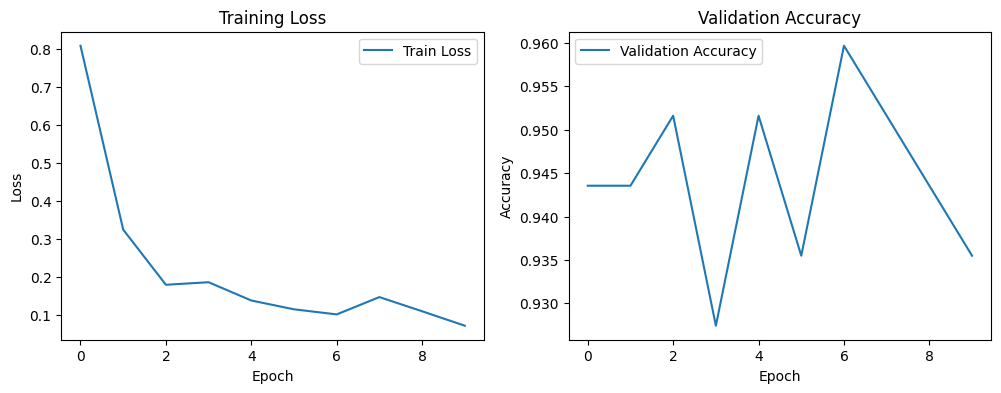

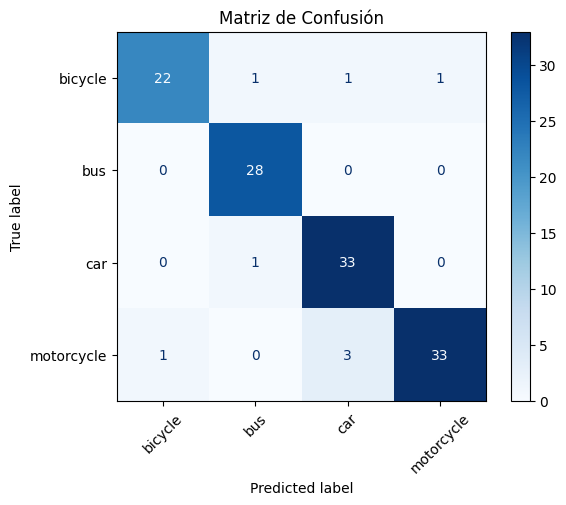

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import warnings

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')

dataset_path = "/content/drive/MyDrive/Dataset"

def load_data(dataset_path):
    """Cargar y transformar los datasets de entrenamiento y validación."""
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    # Transformaciones para el entrenamiento
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomResizedCrop((224, 224), scale=(0.8, 1.0)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Transformaciones para la validación
    val_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    # Carga el dataset completo
    full_dataset = datasets.ImageFolder(root=dataset_path, transform=train_transform)

    # Divide el dataset en entrenamiento y validación
    train_size = int(0.8 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    val_dataset.dataset.transform = val_transform

    return train_dataset, val_dataset

def create_dataloaders(train_dataset, val_dataset, batch_size=32):
    """Crear dataloaders para entrenamiento y validación."""
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader

def initialize_model(num_classes):
    """Inicializar el modelo ResNet50 con capas personalizadas."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = models.resnet50(pretrained=True)

    for param in model.parameters():
        param.requires_grad = False

    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Linear(in_features, 200),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(200, num_classes)
    )
    model = model.to(device)
    return model, device

def train_model(model, device, train_loader, val_loader, epochs=10):
    """Entrenar el modelo y evaluarlo en cada época."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)

    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        val_accuracies.append(accuracy)
        scheduler.step(accuracy)

        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Accuracy: {accuracy:.4f}')

    return train_losses, val_accuracies

def plot_results(train_losses, val_accuracies):
    """Graficar los resultados del entrenamiento y la precisión de validación."""
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

def plot_confusion_matrix(model, val_loader, class_names):
    """Dibujar la matriz de confusión para el conjunto de validación."""
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
    plt.title("Matriz de Confusión")
    plt.show()

# Ejecuta el flujo completo
train_dataset, val_dataset = load_data(dataset_path)
train_loader, val_loader = create_dataloaders(train_dataset, val_dataset)
model, device = initialize_model(len(train_dataset.dataset.classes))
train_losses, val_accuracies = train_model(model, device, train_loader, val_loader)
plot_results(train_losses, val_accuracies)
plot_confusion_matrix(model, val_loader, train_dataset.dataset.classes)


In [ ]:
%reset -f